##  Tensorflow을 이용한 FeedForward Network 구현하기

### _Objective_
1. Boston Dataset 을 이용해 집값을 예측하는 딥러닝 모델을 만들어 봅니다. 


In [0]:
# Boston Data set import numpy as np
import pandas as pd
import tensorflow as tf
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

In [0]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## DataSet 구성하기

In [3]:
boston = load_boston()

# show boston dataset
boston_df = pd.DataFrame(boston['data'],columns=boston['feature_names'])
boston_df['house_price'] = boston['target']

# normalization
mins = boston_df.min()
maxs = boston_df.max()
boston_df = (boston_df - mins) / (maxs - mins)
print('Data Shape : ', boston_df.shape)

# Input & Output Split
xs = boston_df.iloc[:, :13].values

aa = xs.copy()

ys = boston_df.iloc[:, -1].values.reshape([-1, 1])
print('X shape : {}, Y shape : {}'.format(xs.shape, ys.shape))

# 데이터 셋을 나누어 주세요. 
indices = np.asarray(range(len(xs)))
npr.shuffle(indices)

n_train = int(0.6 * len(indices))
n_test = len(indices) - n_train

train_indices , test_indices = np.split(indices, [n_train])

train_xs = xs[train_indices]
train_ys = ys[train_indices]
test_xs = xs[test_indices]
test_ys = ys[test_indices]

Data Shape :  (506, 14)
X shape : (506, 13), Y shape : (506, 1)


## 문제 1. Boston 집값 예측 모델 구성하기

* Tensorflow 을 이용해 아래 Boston 집값을 예측하는 모델을 만들어 봅니다.<br>

** 구현 순서 **
1. ** 모델 생성** <br>
    - Weight의 초기화는 아래와 같습니다.<br>
       * 분포 형태 : 정규분포(Normal Distribution)
       * 평균과 표준편차 : (0, 0.1)

    - Bias의 초기화는 0으로 해줍니다.<br>

    - Activation Function은 모두 `relu`를 이용합니다.<br>

    - 모델의 층 구성은 아래와 같습니다.<br>
 
|layer|입력층|1번째 은닉층|2번째 은닉층|3번째 은닉층|출력층|
|---|---|---|---|---|---|
|shape|(None,13)|(None,64)|(None,128)|(None,256)|(None,1)|
 

2. **학습하기** <br>
 - 손실함수로는 `mean squared error`를 이용해 주세요.
 - Gradient Descent 알고리즘을 이용해 학습시킵니다. 아래의 코드를 이용해 주세요.
 
 ```python
 tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)
 ```

 - 학습률은 0.1로 둡니다.(learning rate = 0.1)<br>
 - step 은 10000 번을 수행합니다.


3. **시각화 하기**<br>
 - train loss , test loss 을 시각화 해봅니다 .<br>
 - 예측이 정답과 얼마나 멀리 떨어져 있는지 파악하기 위해 정답값과 예측값을 하나의 plot에 시각화 합니다. <br>
 시각화 하는 방법은 <br>  scatter 의  x 축은 정답값 ys을 넣고,   scatter y 축은 모델의 예측값을 넣습니다.  
  $y=x$ 에서 벗어난 정도가 정답과 예측이 다른 정도 입니다.

#### 답안지 입력란
* 아래에 답을 서술하여 주세요.


In [4]:
xs = tf.placeholder(tf.float32, [None, 13], name='xs')
ys = tf.placeholder(tf.float32, [None, 1], name='ys')
lr = tf.placeholder_with_default(0.1, [], name='lr')

# Weight 초기화
units = [64, 128, 256]

in_units = 13

a = xs
for i, out_units in enumerate(units):
    with tf.variable_scope('hidden_layer{}'.format(i)):
        # variable declaration
        w = tf.Variable(tf.random.normal([in_units, out_units], stddev=0.1), name='weight')
        b = tf.Variable(tf.zeros([out_units,]),name='bias')
        
        # affine transformation
        z = tf.matmul(a,w) + b
        a = tf.nn.relu(z) 
    
    in_units = out_units
    
with tf.variable_scope('output_layer'):
    w = tf.Variable(tf.random.normal([in_units, 1], stddev=0.1), name='weight')
    b = tf.Variable(tf.zeros([1]),name='bias')
    
    z = tf.matmul(a,w) + b
    y_pred = tf.nn.sigmoid(z) 
output = tf.identity(y_pred,"y_pred")

with tf.variable_scope('loss'):
    loss = tf.reduce_mean((ys-y_pred)**2)
    
show_graph(tf.get_default_graph())

In [5]:
train_op = tf.train.GradientDescentOptimizer(lr).minimize(loss)

W0715 05:26:11.135333 140276355151744 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
n_epoch = 10000

train_pred = []
test_pred = []

train_losses = []
val_losses = []

sess = tf.Session(graph=tf.get_default_graph())
sess.run(tf.global_variables_initializer())

train_feed = {'xs:0' : train_xs, 'ys:0' : train_ys}
val_feed = {'xs:0' : test_xs, 'ys:0' : test_ys}
for epoch in range(n_epoch):
    _, train_loss = sess.run([train_op, loss], feed_dict=train_feed)
    train_losses.append(train_loss)

    val_loss = sess.run(loss, feed_dict=val_feed)
    val_losses.append(val_loss)

In [0]:
train_pred = sess.run(y_pred, feed_dict={xs: train_xs, ys: train_ys})
test_pred = sess.run(y_pred, feed_dict={xs: test_xs, ys: test_ys})

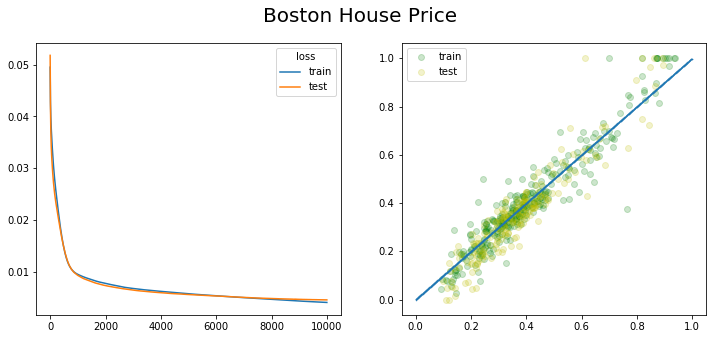

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches((12, 5))

ax1.plot(range(len(train_losses)), train_losses)
ax1.plot(range(len(val_losses)), val_losses)
ax1.legend(['train', 'test'], title='loss')

ax2.scatter(train_pred, train_ys, c='g', alpha=0.2)
ax2.scatter(test_pred, test_ys, c='y', alpha=0.2)

xs = np.arange(0.,1.,0.001)
ax2.scatter(xs, xs, marker='.', s=1)
ax2.legend(['train', 'test'])

fig.suptitle('Boston House Price', fontsize=20, fontweight=5)

plt.show()

#### 정답확인

* 아래와 같은 Loss 추이와 분포를 보이면 성공입니다.


![Imgur](https://i.imgur.com/rokrezs.png)
 